## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

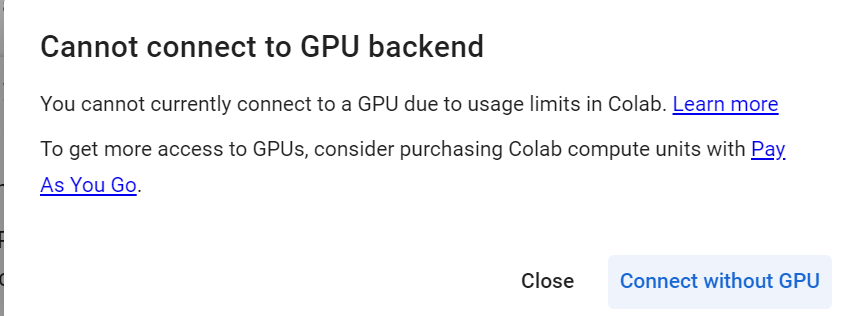

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
# !pip install -U sentence-transformers gensim transformers tqdm -q

In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [3]:
# Mount google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load csv file
stocks = pd.read_csv('/content/stock_news.csv')

In [5]:
# Create copy of dataset
stocks_data = stocks.copy()

## **Data Overview**

In [6]:
# Check first 10 rows of dataset
stocks_data.head(10)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1
5,2019-01-02,Apple CEO Tim Cook discussed the company's Q1 ...,41.740002,42.244999,41.482498,40.246914,130672400,0
6,2019-01-02,Roku Inc has announced plans to offer premium...,41.740002,42.244999,41.482498,40.246914,130672400,1
7,2019-01-02,Wall Street saw modest gains on Wednesday but...,41.740002,42.244999,41.482498,40.246914,130672400,-1
8,2019-01-02,Apple's fiscal first quarter revenue came in ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [7]:
# Check shape of dataset
stocks_data.shape

(349, 8)

* Data consists of 349 rows and 8 columns



In [8]:
# Check data types of columns
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* Dataset has 6 numerical and 2 object type columns
* Data does not have any null value


In [9]:
# Check duplicates in data
stocks_data.duplicated().sum()

0

* Data does not contains any duplicate value

In [10]:
# Change data type of date column to datetime as it is in object type.
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])

In [11]:
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


In [12]:
# Check statistical summary of dataset
stocks_data.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


* The average opening price for stocks is 46.23 dollars with maximun high of 67.06 and low of 37.81 dollars.
* The mean closing price was 44.93, with a maximum of 64.81 and a minimum of 36.25.
* The standard deviation of the closing price was 6.40, indicating moderate fluctuations.
* The high price had a standard deviation of 6.51.
* The average trading volume was 128.95 million shares per day.
The highest volume recorded was 244.44 million, while the lowest was 45.45 million.


## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [13]:
# Observation on Labels
stocks_data['Label'].value_counts()

,count
Label,
0,170
-1,99
1,80


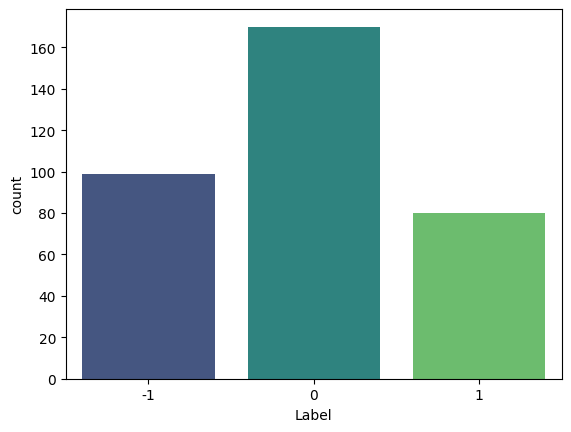

In [14]:
# Plot countplot for lables to visualize label counts
sns.countplot(x='Label', data=stocks_data, palette="viridis")
plt.show()

* As per the count there are 170 neutral, 99 negative and 80 positive labels are there. Which indicates majority i.e. 50% are of neutral sentiments compare to postive and negative

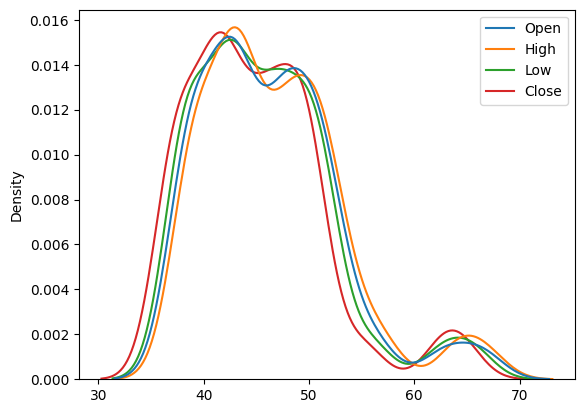

In [15]:
# plot distribution of "Open","High","Low","Close" all in a single plot
sns.kdeplot(data=stocks_data[["Open","High","Low","Close"]])
plt.show()


* The Open, High, Low, and Close prices follow a similar distribution pattern, indicating that stock prices move within a consistent range.
* The distribution appears slightly skewed to the right, meaning there are more instances of lower prices, but some days had much higher prices.
* Since the distribution is smooth and continuous, no extreme outliers are dominating the dataset.
* If the curves were wider, it would indicate higher volatility.

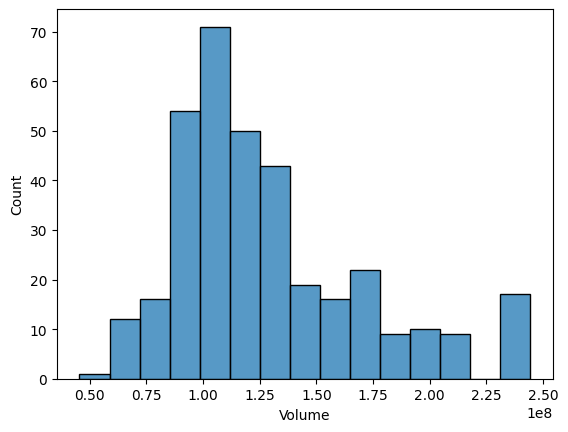

In [16]:
# Observations on Volume
sns.histplot(data=stocks_data, x='Volume')
plt.show()

* Based on plot we can see that volume is distributed from 50 million to 250 million shares
* Majority of the share volume is between 80 to 150 millions

In [17]:
#Calculating the total number of words present in the news content.
stocks_data['Total Words'] = stocks_data['News'].apply(lambda x: len(x.split()))

In [18]:
stocks_data.head()

,Date,News,Open,High,Low,Close,Volume,Label,Total Words
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1,45
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1,50
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1,48
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1,50
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1,49


In [19]:
 #Print the statistical summary for the news content length
stocks_data['Total Words'].describe()

,Total Words
count,349.000000
mean,48.349570
std,5.717324
min,18.000000
25%,45.000000
50%,49.000000
75%,52.000000
max,60.000000


* As per the summary, on an average 48 words are there in new content
* News contains maximum of 60 words to minimum of 18 words

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

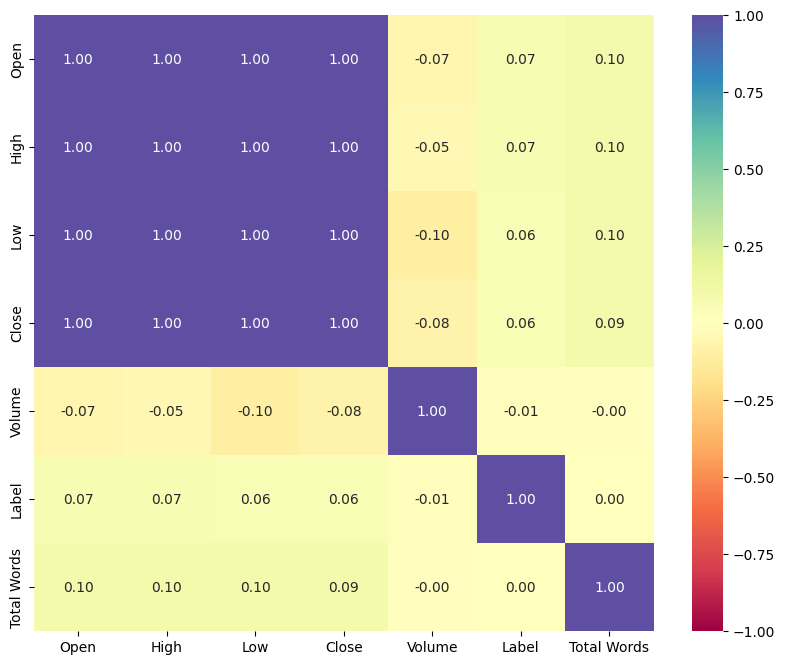

In [20]:
# Plot heatmap to check Correlation
plt.figure(figsize=(10,8))
sns.heatmap(stocks_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()


* The correlation heatmap shows strong positive correlations among Open, High, Low, and Close prices, which is expected. Volume has a weaker correlation with price-related columns.

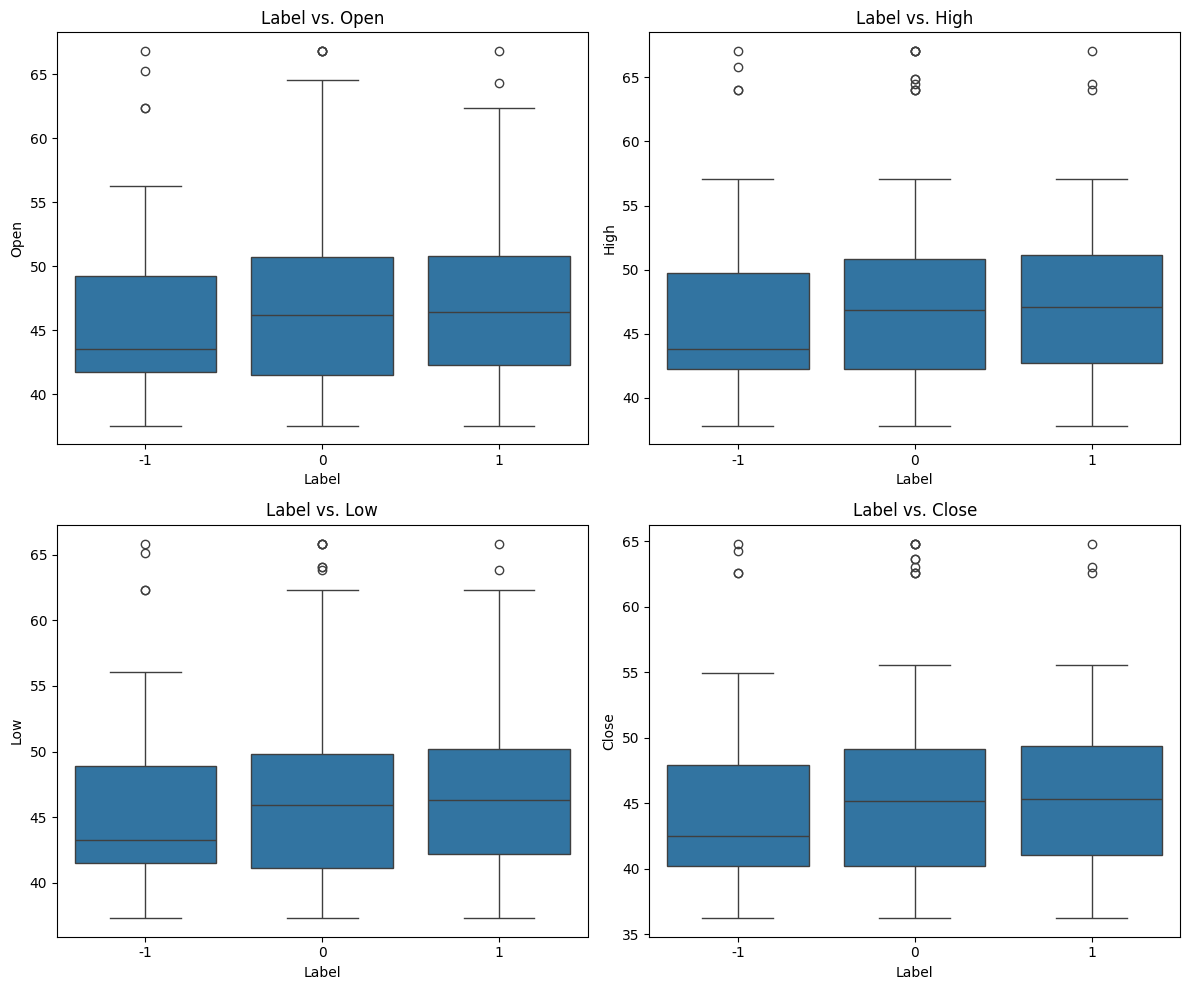

In [21]:
# Boxplot for Label vs. Price (Open, High, Low, Close)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

price_columns = ['Open', 'High', 'Low', 'Close']
for ax, col in zip(axes.flatten(), price_columns):
    sns.boxplot(x=stocks_data['Label'], y=stocks_data[col], ax=ax)
    ax.set_title(f'Label vs. {col}')
    ax.set_xlabel("Label")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

* The boxplots show how stock prices (Open, High, Low, Close) vary with the Label (market sentiment). There may be slight differences in distributions across labels, but further statistical testing would be needed to confirm significance.BD

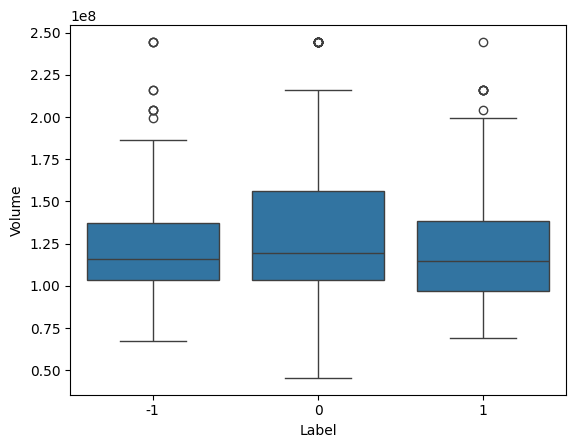

In [22]:
# Label vs Volume
sns.boxplot(x='Label', y='Volume', data=stocks_data)
plt.show()

* As per the plot Neutral stocks has major volume coverage with 50% of stocks ranging from 100 to 150 millions

In [23]:
stock_daily = stocks_data.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


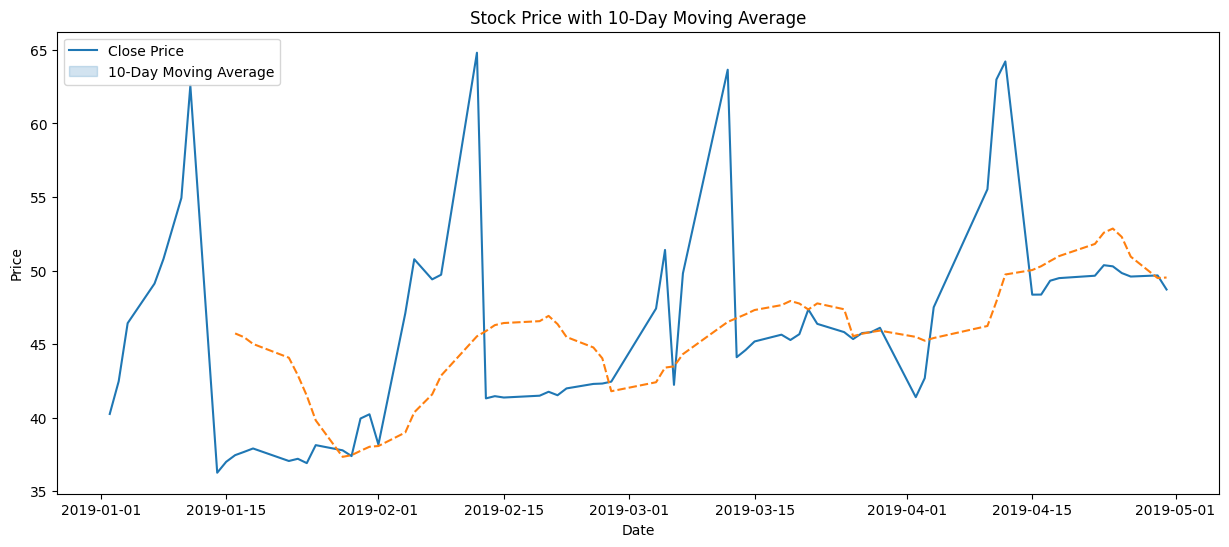

In [24]:
stock_daily['MA_10'] = stock_daily['Close'].rolling(window=10).mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=stock_daily[['Close', 'MA_10']])
plt.title("Stock Price with 10-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(['Close Price', '10-Day Moving Average'])
plt.show()


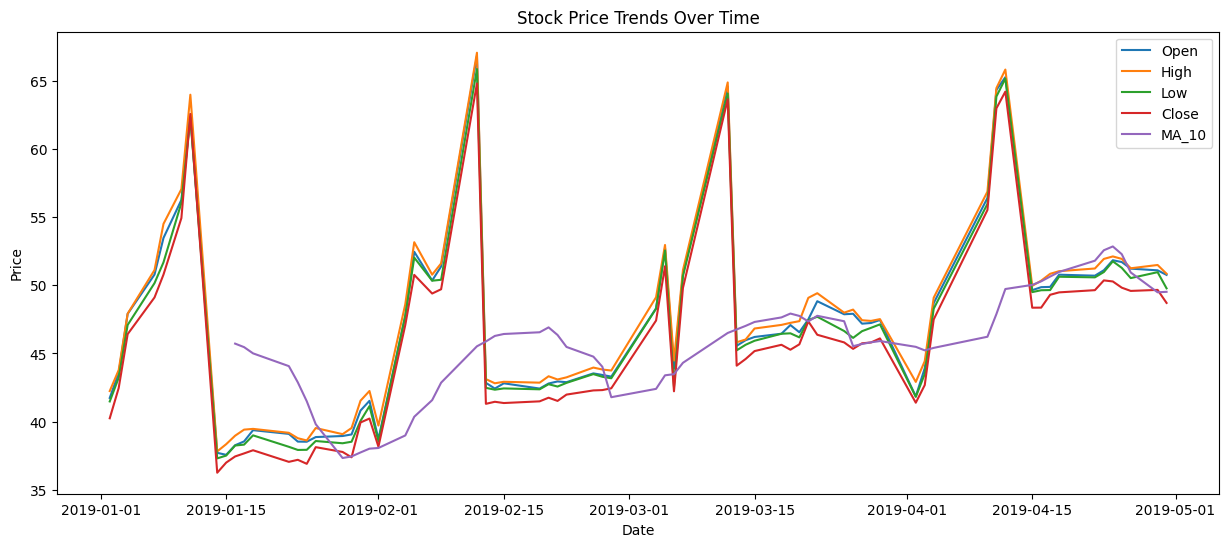

In [25]:
plt.figure(figsize=(15, 6))
for column in stock_daily.drop('Volume', axis=1).columns:
    sns.lineplot(data=stock_daily[column], label=column)

plt.legend()
plt.title("Stock Price Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


* Prices are consistently higher over week and shows downward trend in the middle of the month to month end then it shows upward trend at start of week.
* It shows little fluctuations with lower prices over last weeks of the Months


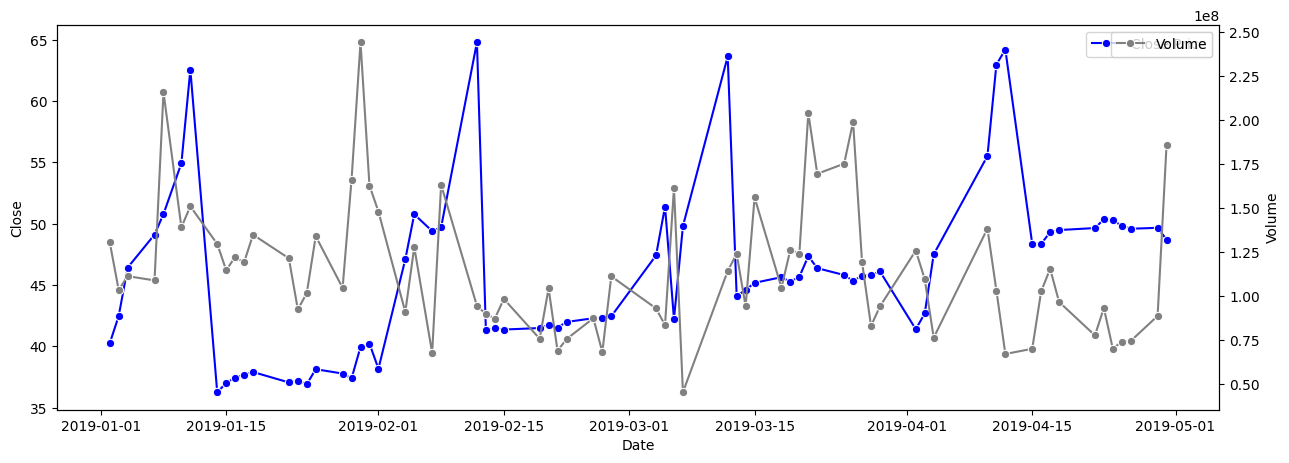

In [26]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

* As per the trend, it can be seen that if closing price goes high the volume goes down. As closing price goes down volume goes up.

## **Data Preprocessing**

### Test Train Validation Split

In [27]:
# Create Train Dataset with all rows where 'Date' is before 2019-04-01
X_train = stocks_data[(stocks_data['Date'] < '2019-04-01')].reset_index()
# Create Validation Dataset with all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_val = stocks_data[(stocks_data['Date'] >= '2019-04-01') & (stocks_data['Date'] < '2019-04-16')].reset_index()
# Create Test Dataset with all rows where the 'Date' is from '2019-04-16' till the end.
X_test = stocks_data[(stocks_data['Date'] >= '2019-04-16')].reset_index()

In [28]:
# Create train, val and test set for target variable
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [29]:
#print the shape data sets
print("X Train data shape",X_train.shape)
print("X Validation data shape",X_val.shape)
print("X Test data shape ",X_test.shape)

print("Y Train label shape",y_train.shape)
print("Y Validation label shape",y_val.shape)
print("Y Test label shape ",y_test.shape)

X Train data shape (286, 10)
X Validation data shape (21, 10)
X Test data shape  (42, 10)
Y Train label shape (286,)
Y Validation label shape (21,)
Y Test label shape  (42,)


In [30]:
X_train.head()

,index,Date,News,Open,High,Low,Close,Volume,Label,Total Words
0,0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1,45
1,1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1,50
2,2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1,48
3,3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1,50
4,4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1,49


## **Word Embeddings**

#### Word2Vec

In [31]:
# List of words in data
words_list = [item.split(" ") for item in stocks_data['News'].values]

In [32]:
# Create an instance of Word2Vec
vec_size = 300
model_w2v = Word2Vec(sentences=words_list, vector_size=vec_size, window=5, min_count=1, workers=6)

In [33]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_w2v.wv.key_to_index)))

Length of the vocabulary is 4682


In [34]:
# Check word embedding for few words
word = 'stock'
model_w2v.wv[word]

array([-4.15914599e-03,  3.76028307e-02,  8.26939382e-03,  1.15105212e-02,
        1.17906230e-03, -5.72689809e-02,  2.85586007e-02,  8.73513669e-02,
        3.89933214e-03, -2.21550576e-02,  6.08450966e-03, -2.08060648e-02,
       -4.83159488e-03,  1.51280044e-02, -2.55383272e-02, -2.70293914e-02,
        2.30980646e-02, -4.19835793e-03,  6.71744021e-03, -2.47360207e-02,
       -2.29110345e-02,  7.78139569e-03,  2.93489415e-02,  1.48616536e-02,
        2.42167525e-02,  5.01552888e-04, -3.54784168e-02,  8.52463953e-03,
       -2.85491832e-02, -4.11973558e-02,  1.00793624e-02, -2.71251053e-02,
        4.91404720e-03, -8.83151311e-03, -1.70924282e-03,  2.30921935e-02,
        1.25018843e-02, -3.41837592e-02, -2.64196401e-03, -1.24084009e-02,
       -2.01347284e-02,  3.70486896e-03, -1.34899383e-04, -2.06691548e-02,
        1.98499318e-02,  3.79057042e-02,  8.71988013e-03,  1.77493542e-02,
        1.38623654e-04,  2.35305913e-02,  1.17881354e-02, -9.29717347e-03,
       -2.06620917e-02,  

In [35]:
word = "fiscal"
model_w2v.wv[word]

array([-1.55491359e-03,  4.42987215e-03,  4.06496198e-04,  2.99835508e-03,
        1.35032122e-03, -1.09302895e-02,  3.62742785e-03,  1.72705986e-02,
        3.26904352e-03, -2.70939339e-03,  1.91163993e-03, -4.97128209e-03,
       -1.78752746e-03,  4.20253398e-03, -6.42764475e-03, -5.81392087e-03,
        4.48358012e-03, -3.42005328e-03,  3.81639670e-03, -7.51257874e-03,
       -2.82002450e-03, -2.13407981e-03,  4.24639974e-03,  9.90445551e-05,
        4.41288250e-03,  1.96967251e-03, -9.25106276e-03,  3.18670063e-04,
       -8.14346317e-03, -1.13611538e-02,  2.81715300e-04, -6.70736236e-03,
        1.57747557e-03, -3.27735883e-03,  5.08701545e-04,  1.28080102e-03,
        3.06090526e-03, -6.71167532e-03, -3.23005905e-03, -1.19205459e-03,
       -5.60054509e-03,  1.71230547e-03, -1.15466258e-03, -1.36297499e-03,
        1.85919926e-03,  1.02567561e-02,  2.19863513e-03,  1.22363691e-03,
       -8.36649677e-04,  5.95082529e-03,  1.99365988e-03,  2.14729179e-03,
       -4.76567680e-03,  

In [36]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_w2v.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_w2v.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [37]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [38]:
# Creating a dataframe for vectorize documents
start = time.time()

X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.43850088119506836


In [39]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


In [40]:
X_train_wv.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,-0.005615,0.032239,0.006177,0.013311,-0.002408,-0.050168,0.025953,0.079987,0.000827,-0.017530,...,0.014626,0.046401,0.031532,-0.001512,0.040316,0.052702,0.006538,-0.020584,0.029551,-0.016742
1,-0.004937,0.031018,0.005324,0.012694,-0.001742,-0.048532,0.025327,0.076958,0.000851,-0.017209,...,0.014023,0.044355,0.030407,-0.001203,0.038550,0.050612,0.006355,-0.019718,0.028624,-0.015926
2,-0.004676,0.029069,0.004496,0.012238,-0.002384,-0.044938,0.023301,0.071475,0.001126,-0.015577,...,0.012733,0.041438,0.028894,-0.001151,0.035953,0.047405,0.006232,-0.018753,0.026514,-0.014791
3,-0.006234,0.033466,0.005939,0.013925,-0.001627,-0.051356,0.027005,0.082254,0.001350,-0.017312,...,0.015547,0.048167,0.031949,-0.001011,0.041772,0.054367,0.006571,-0.021373,0.030208,-0.017158
4,-0.005698,0.031303,0.005516,0.013454,-0.002447,-0.048718,0.025266,0.078244,0.000768,-0.016842,...,0.014651,0.045159,0.030787,-0.001356,0.039631,0.051667,0.006516,-0.020311,0.029182,-0.016222


In [41]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)


(286, 300) (21, 300) (42, 300)


### Using GloVe

In [42]:
# Load glove model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [43]:
# Check the size of Vocabulary
print("Length of the vocabulary is", len(list(glove_model.key_to_index)))

Length of the vocabulary is 400000


Check few word embeddings from glove

In [44]:
# Check word embedding for word
word = 'fiscal'
glove_model[word]

array([ 0.037566 , -0.3505   ,  0.6053   , -0.88877  ,  0.26267  ,
       -0.85035  , -0.41264  ,  0.15612  , -0.38347  ,  0.75271  ,
        0.14319  ,  0.036477 ,  0.21866  ,  0.17531  , -0.046873 ,
       -0.16092  , -0.47602  ,  0.43815  , -0.0029819, -0.54908  ,
        0.29455  , -0.69913  , -0.78756  ,  1.0152   , -1.1138   ,
       -0.22557  ,  0.16026  , -0.7821   , -1.0417   , -0.73787  ,
        0.4298   ,  0.38303  , -0.5378   , -0.52836  , -0.68083  ,
        0.62297  , -0.36233  , -0.14177  ,  0.32653  , -0.014921 ,
       -0.19752  , -0.82104  ,  0.38737  ,  0.83035  , -0.50677  ,
       -0.030901 ,  0.62872  , -0.75123  , -1.0036   , -0.76945  ,
       -0.23083  , -0.56152  , -0.19614  ,  0.79836  , -0.21336  ,
       -2.2264   ,  1.2042   , -0.81874  ,  1.3231   ,  0.41051  ,
       -0.016212 , -0.88813  , -1.8089   ,  0.046677 , -0.10258  ,
       -0.02645  , -1.0452   , -0.59149  ,  1.0489   , -0.75717  ,
        0.7852   ,  0.58732  , -0.746    ,  0.38022  , -0.5429

In [45]:
word = 'shares'
glove_model[word]

array([ 1.3286  ,  0.69354 ,  0.29419 ,  0.66886 ,  0.33194 , -0.8209  ,
        0.017445, -0.37058 , -0.45322 , -0.68676 ,  0.44886 ,  0.35642 ,
       -0.1166  , -0.47337 , -0.34725 , -0.8647  , -0.43301 , -0.092064,
        0.80659 ,  0.49978 ,  0.92839 , -0.48723 ,  0.18957 ,  1.2957  ,
        0.027177, -1.0023  ,  0.48211 ,  0.27344 , -0.6814  , -0.33231 ,
        0.43804 ,  0.85628 , -0.86716 , -0.031107, -0.082545,  0.53319 ,
        1.1965  , -0.057855, -0.068861, -0.35747 ,  0.67171 , -1.2513  ,
       -0.070206, -0.55692 , -0.41302 ,  0.9754  , -0.72807 ,  0.55693 ,
        0.27977 , -1.8509  , -0.30387 ,  0.25268 ,  0.95404 ,  0.47831 ,
       -0.76744 , -1.5847  , -0.35392 , -0.41192 ,  2.387   ,  0.075613,
        0.79698 , -0.26653 , -0.23899 ,  0.33455 , -0.87235 ,  0.14746 ,
        0.71212 ,  0.73689 ,  0.83065 ,  0.36152 , -1.1332  ,  0.14572 ,
       -0.38399 , -0.2714  , -0.55319 , -0.09626 , -0.50378 ,  0.29951 ,
       -1.1838  ,  0.33485 ,  0.4057  , -0.096851, 

In [46]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Retrieving word vectors for all the words present in the model's vocabulary
glove_wvs_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))


In [50]:
vec_size = 100

In [51]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_wvs_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [52]:
# Create a dataframe for vectorized documents using glove model
start = time.time()

X_train_gl = pd.DataFrame(X_train['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  22.611738204956055


In [53]:
# print shapes of train test and val sets for glove
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


## Sentense Transformer

In [54]:
# Define model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Encoding the dataset

In [55]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train['News'].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val['News'].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test['News'].values, show_progress_bar=True, device=device)

end = time.time()
print('Time taken ', (end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  1.0969805717468262


In [57]:
# Print shapes of train, test and Val sets
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**





### Model Evaluation Criteria
**Importance of F1-Score in Sentiment Analysis:**
F1-score is a crucial evaluation metric in stock market news sentiment analysis because it combines precision (correctly identifying relevant sentiments) and recall (capturing all relevant sentiments), ensuring a balanced performance.

**Financial Market Implications:**
In the context of financial markets, misclassification of sentiment (positive or negative) can lead to poor trading decisions, potentially affecting investments, market predictions, and profits.

**Reducing Risks:**
A high F1-score ensures that both positive and negative sentiments are captured accurately. This balance reduces the risk of biased or misleading sentiment analysis, which could otherwise lead to skewed or incorrect market predictions.

**Enhanced Decision Making:**
By using F1-score, financial analysts can trust that the model's predictions are robust and minimize the risk of relying on inaccurate sentiment information when making trading decisions.

So **F1-score** is chosen as a key evaluation metric for stock market news sentiment analysis.








#### Utility Functions

In [60]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [61]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [62]:
# Building the model

#base_wv = GradientBoostingClassifier(random_state = 42)
base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

RandomForestClassifier(random_state=42)

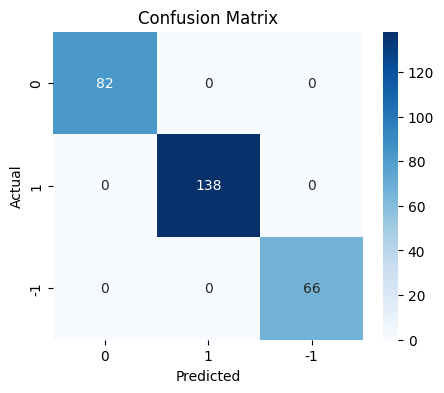

In [63]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

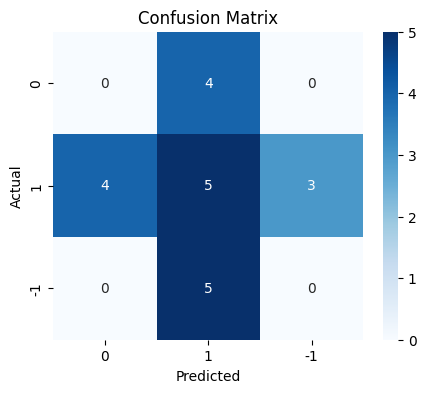

In [64]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [67]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [68]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.238095  0.238095   0.204082  0.21978


In [69]:
# Print classification report
print(classification_report(y_val, base_wv.predict(X_val_wv)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.36      0.42      0.38        12
           1       0.00      0.00      0.00         5

    accuracy                           0.24        21
   macro avg       0.12      0.14      0.13        21
weighted avg       0.20      0.24      0.22        21



* The Model is overfitting and achieved only ~22% of f1 score

### Base Model - GloVe

In [70]:
#Building the model

base_gl = RandomForestClassifier(random_state=42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train)

RandomForestClassifier(random_state=42)

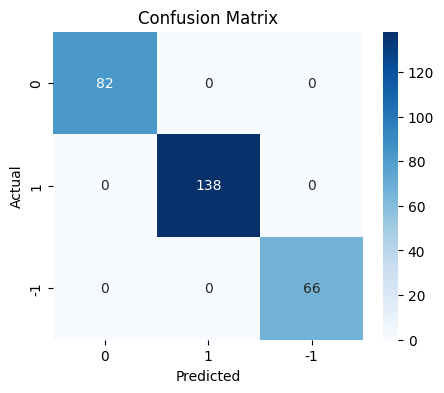

In [71]:
# plot the confusion matrix for the train data
plot_confusion_matrix(base_gl,X_train_gl,y_train)

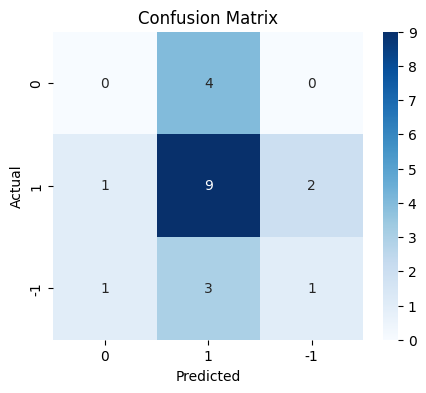

In [72]:
# plot the confusion matrix for the validation data
plot_confusion_matrix(base_gl,X_val_gl,y_val)

In [73]:
#Calculating different metrics on training data
base_train_gl= model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [74]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


* As per the scores on training and validation sets the model is overfitting and giving result with 43% F1 score. Better than earlier model.

### Base Model - Sentence Transformer

In [75]:
# Building the model

base_st = RandomForestClassifier(random_state=42)

# fitting the model
base_st.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

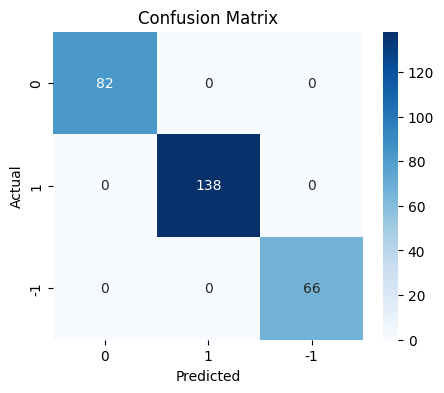

In [76]:
# plot confusion matrix for the training data
plot_confusion_matrix(base_st,X_train_st,y_train)

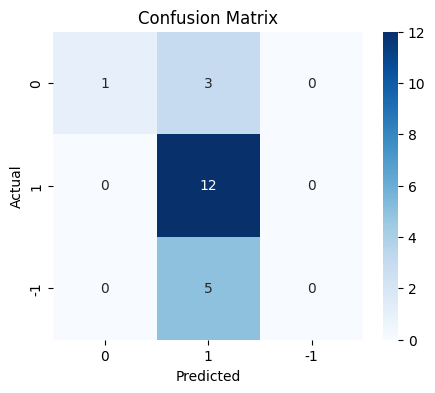

In [77]:
# plot confusion matrix for validation data
plot_confusion_matrix(base_st,X_val_st,y_val)

In [78]:
# Calculate different metrics on training data
base_train_st = model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [79]:
# Calculate performance matrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048   0.533333  0.504762


* As per the results on train and validation st the model is overfitting
* But Model is giving ~50% F1 score which better compare to above 2 models

### Tuned Model - Word2Vec

In [81]:
# Build the model
start = time.time()

tuned_wv = RandomForestClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,10),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4],
    'bootstrap': [True, False]  # Bootstrapping for variance reduction
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  139.68320322036743


In [82]:
# Fit the best model from grid search to the data.
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_split=5,
                       random_state=42)

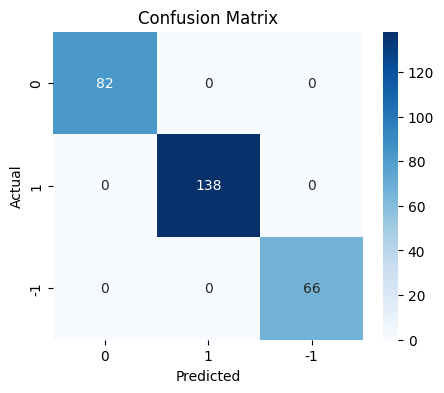

In [83]:
# plot confusion matrix
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

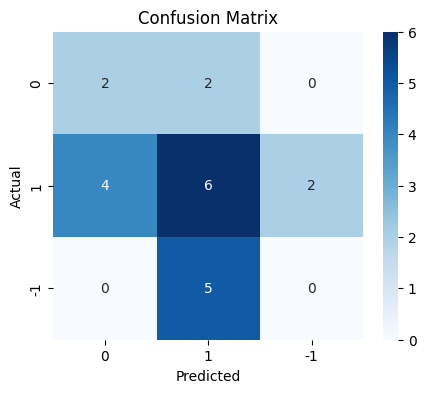

In [84]:
# plot confusion matrix for validation data
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [85]:
# Calculate performance metrics for training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [86]:
# Calculate performance metrics for validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.327228  0.350476


* As per the results on train and validation set The Model is overfitting
* Model is giving 35% F1 score on validation set

### Tuned Model - GloVe

In [134]:
# Build the model
start = time.time()

tuned_mgl = RandomForestClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_mgl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  19.118369817733765


In [135]:
# fit the best parameter model to train data
tuned_gl.fit(X_train_gl, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=7,
                       random_state=42)

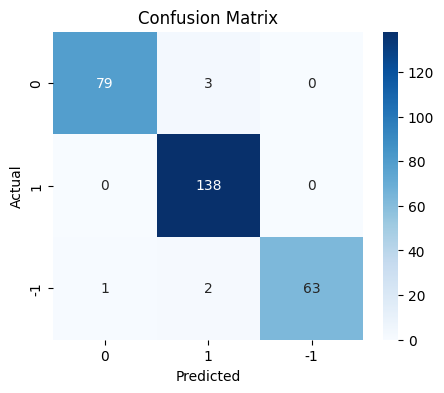

In [136]:
# Plot confusion matrix for training data
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

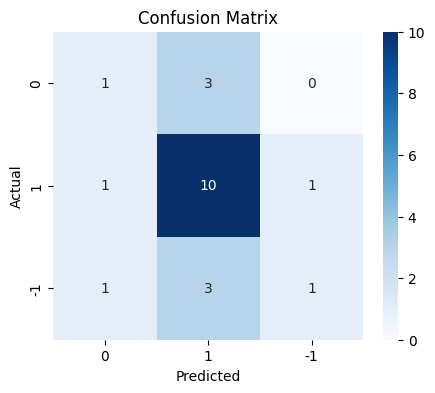

In [137]:
# plot confusion matrix for validation data
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [138]:
# Calculate performance matrix for training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979021  0.979021   0.979545  0.978968


In [139]:
# Calculate performance matrix for validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.539683  0.530612


In [140]:
# Print classification report
print(classification_report(y_val, tuned_gl.predict(X_val_gl)))

              precision    recall  f1-score   support

          -1       0.33      0.25      0.29         4
           0       0.62      0.83      0.71        12
           1       0.50      0.20      0.29         5

    accuracy                           0.57        21
   macro avg       0.49      0.43      0.43        21
weighted avg       0.54      0.57      0.53        21



* After hyper parameter tunning the model performance has improved compare to base model
* Model is giving ~53% F1 score on validation set.

### Tuned Model - Sentence Transformer

In [181]:
# Build the model
start = time.time()

tuned_mst = RandomForestClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,10),
#'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_mst, parameters, scoring='f1_weighted',cv=5,n_jobs=-1) #Complete the code to pass the chosen model
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  19.015954971313477


In [182]:
# Fit the best parameter model on train data
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=9, max_features=0.2, random_state=42)

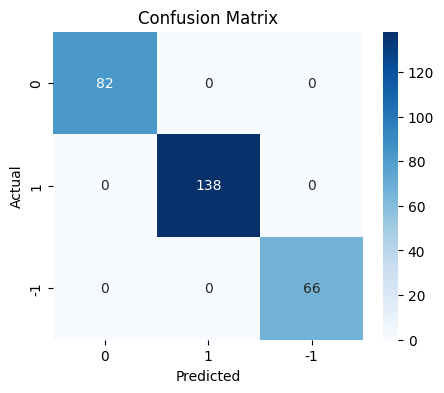

In [183]:
# plot confusion matrix for training data
plot_confusion_matrix(tuned_st,X_train_st,y_train)

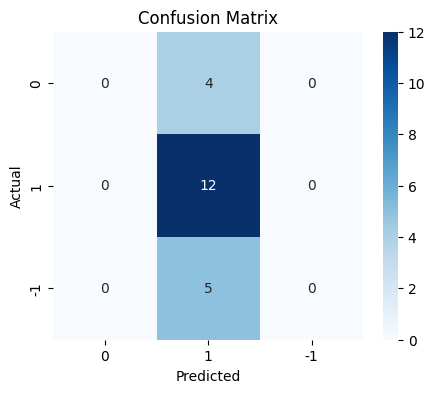

In [184]:
# plot confusion matrix for validation set
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [185]:
# Calculate performance matrix for trainin data
tuned_train_st = model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [186]:
# Calculate performance matrix for validation set
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.326531  0.415584


* After hyper parameter tunning the model performance has improved a bit compare to base model
* Model is giving ~42% F1 score on validation set, still model seems to be overfitting.

### Model performance comparison and final model selection

In [141]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,1.0,0.979021,1.0
Recall,1.0,1.0,1.0,1.0,0.979021,1.0
Precision,1.0,1.0,1.0,1.0,0.979545,1.0
F1,1.0,1.0,1.0,1.0,0.978968,1.0


* As we can see all the models are overfitting on training data with based as well as tuned model.

In [142]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.238095,0.476190,0.619048,0.380952,0.571429,0.523810
Recall,0.238095,0.476190,0.619048,0.380952,0.571429,0.523810
Precision,0.204082,0.400794,0.533333,0.327228,0.539683,0.314286
F1,0.219780,0.426871,0.504762,0.350476,0.530612,0.392857


*  Based on above performance matrix, all models are giving around ~50-55% score, based on the result, I would suggest Tuned Glove model as final model with 53% F1 score on validation set.
*  The score can be improved further if more data is available to train the model, as well as some more trials on hyper parameter tunning may give better results

### Final Model performance check on Test Data

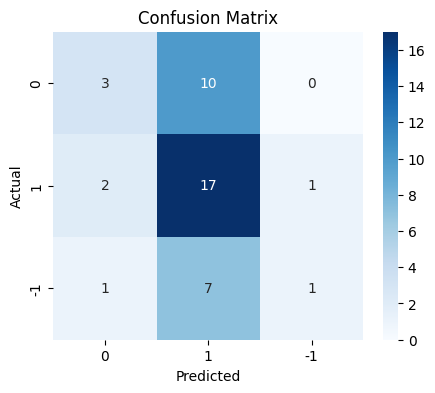

In [187]:
# Check Best Model performance on test data
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

In [188]:
# Check peroformance metrics
model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test)

,Accuracy,Recall,Precision,F1
0,0.5,0.5,0.5,0.436529


+ The tuned glove model is giving 44% F1 score on test data.


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 181.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 276.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 254.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.16 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.2.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 wh

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd
import numpy as np

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
stock_news = pd.read_csv('/content/stock_news.csv')

In [ ]:
data = stock_news.copy()

#### Loading the model

In [ ]:
# loading the model
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
llm = Llama(
    model_path=model_path, # Path to the model
    n_gpu_layers=100, #Number of layers transferred to GPU
    n_ctx=4500, #Context window
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
# Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=512,  # Set maximum tokens for response length
      temperature=0.7,  # Controls creativity; lower = more deterministic
      top_p=0.9,  # Nucleus sampling for diverse responses
      top_k=40,   # Limits token selection for coherence
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
#Complete the code to define the prompt for this task
prompt = """
You are an expert AI assistant specializing in news content analysis.

Task: Identifying events that are most likely to impact the price of the stock.

Instructions:
1. Read the weekly news carefully.
1. Analyze the events likey to impact the price of the stock
3. List the top three negative events and summarize in concise manner.
2. List the top three positive events and summarize in a concise manner.

Return a JSON containing two keys, one for Positive Events and one for Negative Events..
"""

In [ ]:
# test out the prompt with one instance before using it for the entire weekly data.
%%time
summary = response_mistral_1(prompt, news)
print(summary)

 {
         "Positive Events": [
           {
             "Description": "Roku Inc announces plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
             "Impact": "This news could positively impact Apple as it also follows Amazon's successful Channels business model and could potentially increase user engagement and revenue for the company."
           },
           {
             "Description": "President Trump expresses optimism over potential trade talks with China, citing China's current economic weakness as a potential advantage for the US.",
             "Impact": "A successful trade deal between the US and China could potentially boost global market sentiment and improve investor confidence, leading to a positive impact on Apple's stock price."
           },
           {
             "Description": "The Chinese central bank announces a fifth reduction in the required reserve ratio (RRR) for banks, freeing up

##### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

100%|██████████| 18/18 [07:17<00:00, 24.33s/it]

CPU times: user 26min 57s, sys: 26.2 s, total: 27min 23s
Wall time: 7min 17s


In [ ]:
# print the first 5 rows of the 'Key_Events' column
data_1['Key Events'].head(5)

,Key Events
0,"{\n ""Positive Events"": [\n ..."
1,"{\n ""Positive Events"": [\n ..."
2,"{\n ""Positive Events"": [\n ..."
3,"{\n ""Positive Events"": [\n ..."
4,"{\n ""Positive Events"": [\n ..."


##### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

Error parsing JSON: Expecting property name enclosed in double quotes: line 20 column 13 (char 1282)
Error parsing JSON: Expecting ',' delimiter: line 24 column 13 (char 2137)


,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Description': 'Roku Inc...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Event': 'Sprint and Sam...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Description': 'Dialog S...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Event': 'IBM's better-t...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""Positive Events"": [\n ...",{}


In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,[{'Description': 'Roku Inc announces plans to ...,[{'Description': 'Apple lowers its fiscal Q1 r...
1,[{'Event': 'Sprint and Samsung plan to release...,[{'Event': 'Geely forecasts flat sales for 201...
2,[{'Description': 'Dialog Semiconductor reporte...,[{'Description': 'China's unexpected drops in ...
3,[{'Event': 'IBM's better-than-expected earning...,[{'Event': 'White House rejects scheduled meet...
4,NaN,NaN


In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,[{'Description': 'Roku Inc announces plans to ...,[{'Description': 'Apple lowers its fiscal Q1 r...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[{'Event': 'Sprint and Samsung plan to release...,[{'Event': 'Geely forecasts flat sales for 201...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[{'Description': 'Dialog Semiconductor reporte...,[{'Description': 'China's unexpected drops in ...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[{'Event': 'IBM's better-than-expected earning...,[{'Event': 'White House rejects scheduled meet...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,NaN,NaN


## **Conclusions and Recommendations**

### **Conclusions**

**Sentiment Distribution Analysis**

* The stock market sentiment was categorized into positive, negative, and neutral sentiments, providing insights into market trends and investor sentiment.

**Embedding Techniques and Model Performance**

* Various word embedding techniques such as Word2Vec, GloVe, and Sentence Transformers were used to encode news articles and train machine learning models.
* The Tuned GloVe model performed best, achieving an F1 score of 53% on the validation set and 44% on the test set.
* The limited dataset (349 rows) significantly impacted model performance, making it difficult to achieve desired results.

**Business Implications of Sentiment Analysis**

* Sentiment analysis can assist organizations in strategic decision-making by providing insights into investment strategies and risk management.
* Sentiment distributions can be used to predict stock market movements, giving investors a data-driven advantage.
* Positive sentiment can be leveraged for financial communications, while negative and neutral sentiments can help guide risk mitigation strategies.

**Proactive Financial Risk Management**

* Identifying negative sentiment early can enable proactive responses, reduce financial risks, and boost stakeholder confidence.

### **Recommendations**

**Enhancing Model Performance**

* Increase dataset size: Training the model on a larger dataset will likely improve accuracy and generalization.
* Exploring transformer-based models (BERT) tailored for financial sentiment analysis may yield better results.
* Hyperparameter Optimization: Further tuning of hyperparameters (learning rate, batch size, and optimizer) can enhance model performance.

**Practical Applications for Financial Institutions**

* Implement sentiment analysis tools for real-time market monitoring to track investor sentiment and predict stock fluctuations.
* Develop automated trading strategies based on sentiment trends to capitalize on market movements.
* Utilize negative sentiment detection for early risk identification and mitigation planning in investment strategies.

**Future Research and Development**

* Explore multi-modal approaches combining textual sentiment analysis with financial time-series data for enhanced predictive power.
* Investigate ensemble models that integrate multiple NLP techniques to improve robustness.
* Evaluate alternative data sources, such as social media trends and analyst reports, to complement sentiment analysis.

<font size=6 color='blue'>Power Ahead</font>
___